# MNIST Classifier

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import numpy as np

from scipy.stats import randint
from scipy.ndimage import shift

RANDOM_STATE = 42

## Fetch data

In [2]:
# Servers are down (Read-only server is available)
# https://github.com/orgs/openml/discussions/20
# 
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
import openml
openml.config.server = "http://145.38.195.79/api/v1/xml" # Point to the read-only server
mnist = openml.datasets.get_dataset(554, download_data=True) # version 2 of the dataset
X, y, *_ = mnist.get_data(target="class")

## Explore data

In [4]:
X = X.to_numpy()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [5]:
# 70k images of 28x28 (784) size
X.shape

(70000, 784)

In [6]:
y = y.to_numpy()
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

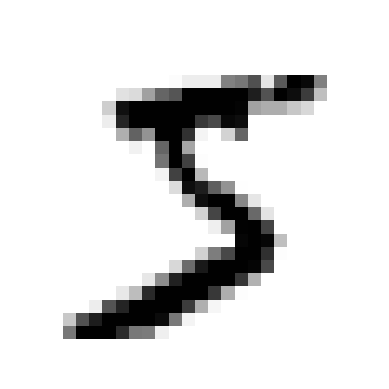

In [8]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

## Default parameters

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [20]:
knn = KNeighborsClassifier()

In [35]:
cross_val_score(knn, X_train, y_train, cv=10).mean()

0.970875

In [21]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [22]:
baseline_accuracy = knn.score(X_test, y_test)
baseline_accuracy

0.9700714285714286

In [ ]:
untuned_predictions = knn.predict(X_test)
untuned_accuracy_score = accuracy_score(y_test, untuned_predictions)
print(untuned_accuracy_score)

0.9700714285714286


## Hyperparameter tuning

In [33]:
params = {
    "n_neighbors": randint(low=1, high=31),
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "euclidean", "manhattan"],
}

knn_cv = RandomizedSearchCV(
    knn, param_distributions=params, n_iter=20, cv=5, verbose=1, scoring="accuracy"
)
knn_cv.fit(X_train[:10000], y_train[:10000])
print(knn_cv.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [37]:
cross_val_score(knn_cv.best_estimator_, X_train, y_train, cv=10).mean()

0.9727321428571429

In [34]:
knn_cv.best_estimator_.fit(X_train, y_train)

tuned_predictions = knn_cv.predict(X_test)
tuned_accuracy_score = accuracy_score(y_test, tuned_predictions)
print(tuned_accuracy_score)

0.9728571428571429


## Data augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

Just copying the solution here to see how it performs on my model.

In [38]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

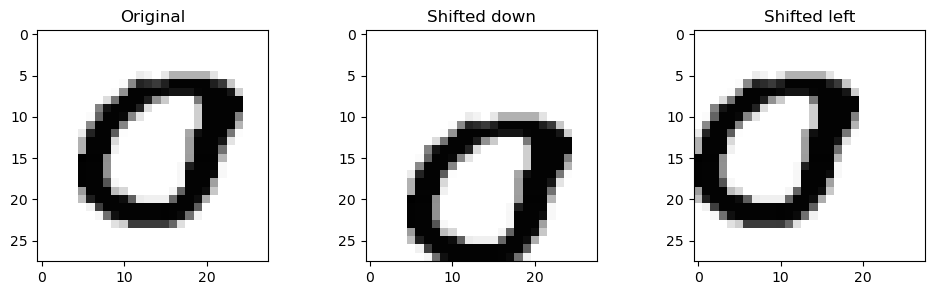

In [43]:
image = X_train[100]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [44]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [45]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [46]:
knn_clf = KNeighborsClassifier(**knn_cv.best_params_)

In [47]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [48]:
augmented_accuracy_score = knn_clf.score(X_test, y_test)
augmented_accuracy_score

0.9798571428571429

In [50]:
error_rate_change = (1 - augmented_accuracy_score) / (1 - tuned_accuracy_score) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -26%
